In [1]:
import sys 
sys.path.append('..')
import alpenglow.files as af
import matplotlib.pyplot as plt
%matplotlib inline
import skimage.external.tifffile as tiff
from skimage import transform
from skimage import img_as_int
from skimage import data
from skimage.transform import swirl
import skimage as skimage
import numpy as np
import shutil as sh
import os
import boto3
from scipy import optimize
import alpenglow.stitching as ast
import alpenglow.stitching2 as ast2
from imp import reload
from alpenglow.stitching import stitch, find_shift, apply_shift, calc_coef, output_zstack, stitch_zstack
from alpenglow.stitching2 import stitch, find_shift, apply_shift, calc_coef, output_zstack, stitch_zstack

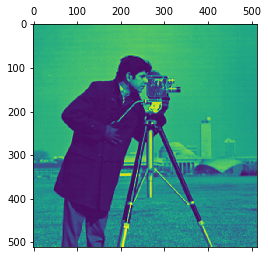

In [2]:
camera = data.camera()
plt.matshow(camera)

In [3]:
camera.shape

(512, 512)

In [3]:
image1 = camera[50:200]
image2 = camera[150:300]
image3 = camera[250:400]

In [4]:
image1 = np.pad(image1, ((0,0),(0,38)), 'constant', constant_values=(0))
image2 = np.pad(image2, ((0,0),(38,0)), 'constant', constant_values=(0))
image3 = np.pad(image3, ((0,0),(19,19)), 'constant', constant_values=(0))

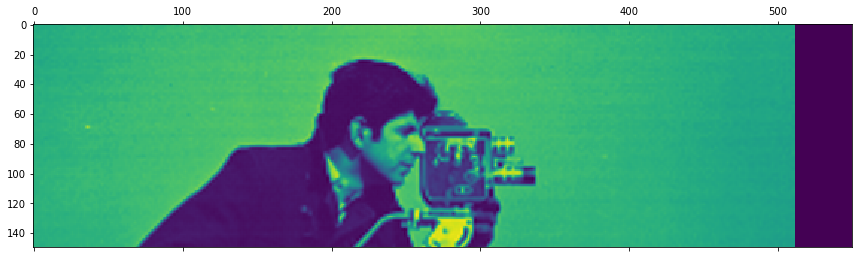

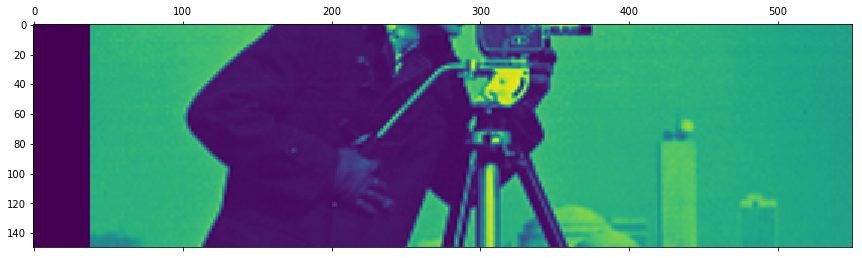

In [6]:
plt.matshow(image1)
plt.matshow(image2)

In [7]:
image2.shape

(150, 550)

### Playing with apply_shift

In [11]:
translation = skimage.feature.register_translation(image2, image1)
translation = translation[0]
translation

array([ 50.,  38.])

In [64]:
shift = test_apply_shift(image2, image1, translation, margin=30)

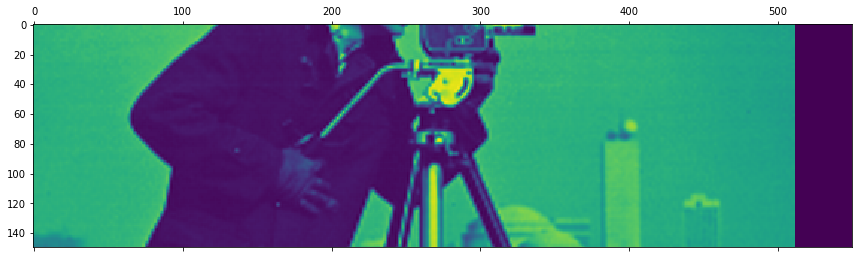

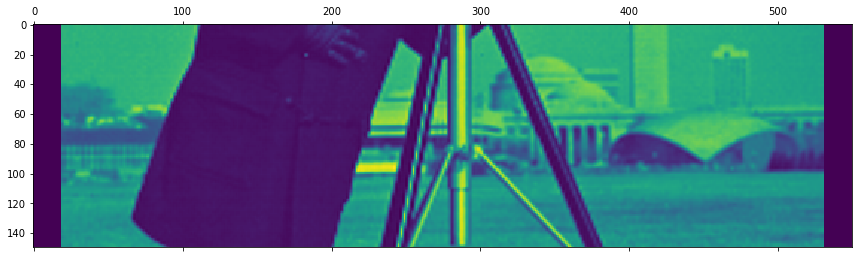

In [71]:
plt.matshow(shift[100:250],)
plt.matshow(image3)

In [68]:
image3.shape

(150, 550)

In [73]:
translation = skimage.feature.register_translation(image3, shift[100:250,])
translation = translation[0]
translation

array([ 51.,  19.])

In [74]:
all_three = test_apply_shift(image3, shift, translation, margin=30)

(349, 550)

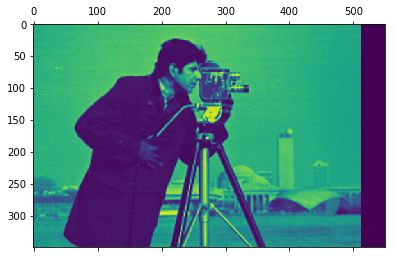

In [76]:
plt.matshow(all_three)
all_three.shape

In [57]:
def test_apply_shift(image1, image2, shift, margin=30):
    """ 
    Apply a lateral shift between two images, stitching them together
    
    Parameters
    ----------
    image1, image2 : 2D arrays
        The images to be stitched, *in order* (bottom, top)
    
    shift : sequence of length 2 
        x, y lateral shifts
    
    Returns
    -------
    Stitched image
    
    """
    cols1 = image1.shape[1]
    cols2 = image2.shape[1]
    rows1 = image1.shape[0]
    rows2 = image2.shape[0]

    overlap = int(abs(shift[0]))
    registered = np.zeros((rows1 + rows2 - overlap, cols1), dtype=int)
    registered[:rows2-margin] = image2[:rows2-margin]
    if shift[1] >= 0:
        registered[rows2-margin:, :cols1-int(shift[1])] = image1[overlap-margin:, int(shift[1]):] 
    else:
        registered[rows2-margin:, abs(int(shift[1])):] = image1[overlap-margin:, :int(shift[1])] 
    
    if margin > 0:
        fade2 = image2[rows2 - margin:rows2] * np.arange(1, 0, -(1/margin))[:, np.newaxis]
        fade1 = np.zeros_like(fade2)
        if shift[1] >= 0:
            fade1[:, :cols1-int(shift[1])] = (image1[overlap-margin:overlap, int(shift[1]):] * 
                                              np.arange(0, 1, (1/margin))[:, np.newaxis])
        else:
            fade1[:, abs(int(shift[1])):] = image1[overlap-margin:overlap, :int(shift[1])] * np.arange(0, 1, (1/margin))[:, np.newaxis]

        registered[rows2 - margin:rows2] = fade1 + fade2

    return registered.astype(int)

#### The problem was with overlap, switched to abs(shift[0])

### Now we have to fix find_shift

In [18]:
shift = ast2.find_shift(image2, image1)
shift

array([-25.,  38.])

In [36]:
translation = skimage.feature.register_translation(image2[0:150,:], image1[0:150,:])
translation

(array([ 50.,  38.]), 0.49365498026746202, 6.1805587162139333e-16)

#### Problem is that a subsample of the image leads to poor registration in wide dimension

In [10]:
mosaic_12 = mosaic_12[0]

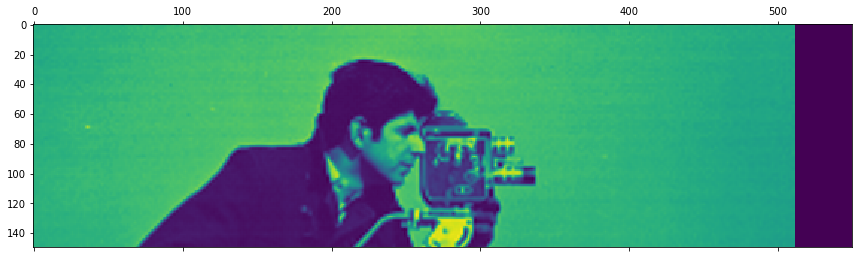

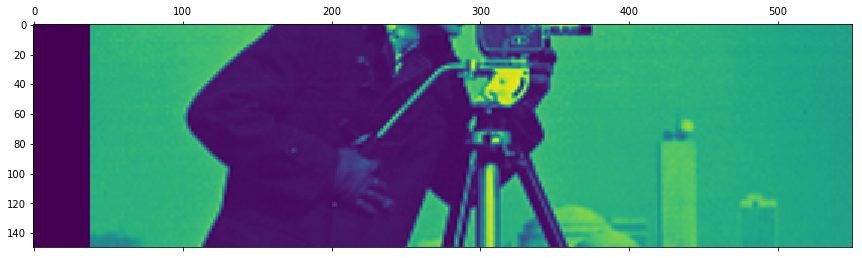

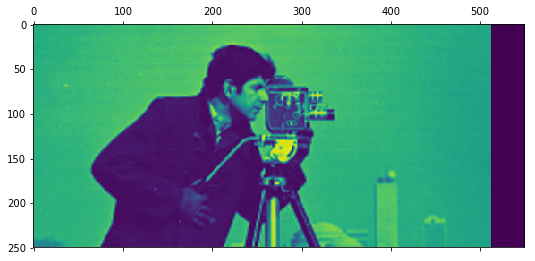

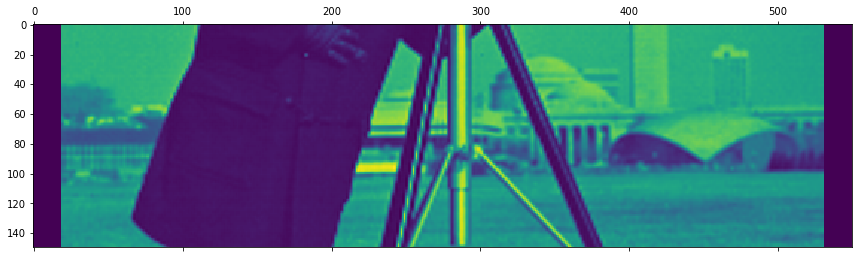

In [11]:
plt.matshow(image1)
plt.matshow(image2)
plt.matshow(mosaic_12)
plt.matshow(image3)

In [12]:
mosaic_12.shape

(250, 550)

In [12]:
mosaic_123 = ast2.stitch(image3, mosaic_12, margin = 30)

ValueError: operands could not be broadcast together with shapes (4,531) (30,1) 

In [13]:
debug

> /home/nicholasreder/alpenglow/alpenglow/stitching.py(100)apply_shift()
     98         if shift[1] >= 0:
     99             fade1[:, :cols1-int(shift[1])] = (image1[overlap-margin:overlap, int(shift[1]):] * 
--> 100                                               np.arange(0, 1, (1/margin))[:, np.newaxis])
    101         else:
    102             fade1[:, abs(int(shift[1])):] = image1[overlap-margin:overlap, :int(shift[1])] * np.arange(0, 1, (1/margin))[:, np.newaxis]

ipdb> overlap
176
ipdb> shift
array([ 51.,  19.])
ipdb> q


In [133]:
image1 = (skimage.filters.gaussian(camera, 1)*255).astype('uint8')   
image2 = (skimage.filters.gaussian(camera, 2)*255).astype('uint8')    
image3 = (skimage.filters.gaussian(camera, 3)*255).astype('uint8')    
image4 = (skimage.filters.gaussian(camera, 4)*255).astype('uint8')    
image5 = (skimage.filters.gaussian(camera, 5)*255).astype('uint8')    

In [134]:
list_camera = camera, image1, image2, image3, image4, image5
z_camera = np.dstack(list_camera)

In [137]:
mosaic_12 = ast.stitch(z_camera[150:300,:,4], z_camera[50:200,:,4], margin = 40)

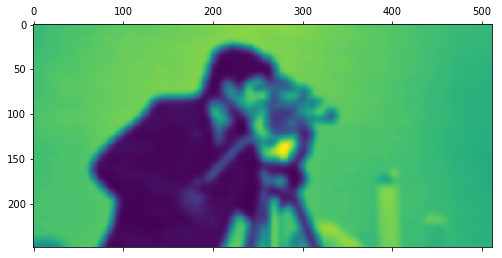

In [138]:
plt.matshow(mosaic_12[0])

In [143]:
mosaic = ast.stitch_zstack(z_camera[150:300,:,:], z_camera[50:200,:,:],1)

../alpenglow/stitching.py:204: UserWarning: I am having trouble finding a good registration. Defaulting to no shift
  warnings.warn("I am having trouble finding a good registration. Defaulting to no shift")


In [144]:
debug

> <ipython-input-139-9c98600595d5>(1)<module>()
----> 1 mosaic = ast.stitch_zstack(z_camera[150:300,:,:], z_camera[50:200,:,:])

ipdb> overlap
*** NameError: name 'overlap' is not defined
ipdb> shift
array([  0.,  15.])
ipdb> coef
*** NameError: name 'coef' is not defined
ipdb> q


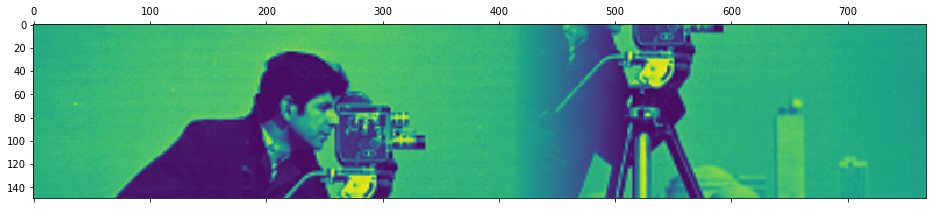

In [142]:
plt.matshow(mosaic[:,:,0])

In [146]:
coeffs = ast.calc_coef(z_camera[150:300,:,:], z_camera[50:200,:,:],1,1)

In [147]:
coeffs

(array([ -1.12,  31.48]), array([[-20.,   0.],
        [-29.,   0.],
        [-56.,   0.],
        [-67.,   0.],
        [-85.,   0.]]))

In [154]:
shift_2 = ast.find_shift(z_camera[150:300,:,2], z_camera[50:200,:,2])
shift_2

array([-25.,   0.])

In [156]:
z_camera.shape

(512, 512, 6)

In [157]:
z_camera = np.memmap(z_camera)

TypeError: Can't convert 'numpy.ndarray' object to str implicitly